In [ ]:
# import various libraries
import numpy as np
import csv
import pandas as pd
import argparse
import sklearn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_validate, permutation_test_score, GroupShuffleSplit, LeaveOneGroupOut
from sklearn.inspection import permutation_importance
from sklearn import metrics
from sklearn.metrics import make_scorer, r2_score
from pathlib import Path
import matplotlib.pyplot as plt
import statistics
import math

In [ ]:
# parse arguments
dir = '/content/drive/MyDrive/FateTrack/0716/' #directory where training/test data is saved
suff = '0716_allNuc_q25_2-cy3_2-yfp_2-cy5_1-yfp_1-cy5_latent' #data suffix (usually date)
out = '0716_allNuc_q25' #output suffix (usually same as suff)
classification_bool = False

In [ ]:
# import data
def get_dataset1(feat = True, classification = True):
    if feat: # using features
        X = pd.read_csv(dir + "nuclei_feat_" + suff + ".csv", header = None)
        sclr = StandardScaler()
        X = sclr.fit_transform(X)
    else: # using images
        X_raw = np.load(dir + "nuclei_" + suff + ".npy")
        X = np.zeros((X_raw.shape[0], X_raw.shape[1]**2))
        for i in range(X_raw.shape[0]):
            X[i] = X_raw[i].flatten()
    if classification: # classification
        y = np.asarray(pd.read_csv(dir + "nuclei_id_" + suff + ".csv", header = None))
        encoder = LabelBinarizer()
        y = encoder.fit_transform(y)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 2, stratify = y) # use stratify for classification
    else: # regression
        encoder = []
        y = np.asarray(pd.read_csv(dir + "nuclei_meas_" + suff + ".csv", header = None))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 2)
    return X, y, X_train, X_test, y_train, y_test, encoder

def get_dataset(feat = True, classification = False):
    encoder = []
    X = pd.read_csv(dir + "nuclei_feat_" + suff + ".csv", header = None)
    sclr = StandardScaler()
    X = sclr.fit_transform(X)
    y = np.asarray(pd.read_csv(dir + "nuclei_meas_" + suff + ".csv", header = None))
    groups = np.asarray(pd.read_csv(dir + "nuclei_samples_" + suff + ".csv", header = None))
    gss = GroupShuffleSplit(n_splits = 1, test_size = 1, random_state = 3)
    split_it = gss.split(X, y, groups)
    train_ix, test_ix = next(split_it)
    print("Testing Group: " + groups[test_ix[0]])
    return X, y, X[train_ix], X[test_ix], y[train_ix], y[test_ix], groups

# create model
def get_model(n_est, classification):
    if classification:
        model = RandomForestClassifier(n_estimators = n_est)
    else: #regression
        model = RandomForestRegressor(n_estimators = n_est, max_features = 0.3)
    return model

In [ ]:
X, y, X_train, X_test, y_train, y_test, encoder = get_dataset(classification = classification_bool)

model = get_model(n_est = 500, classification = classification_bool)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# export results
if classification_bool:
    to_export = pd.DataFrame()
    to_export['Pred'] = y_pred
    to_export['True'] = y_test
    to_export.to_csv(dir + "results_" + out + ".csv")

    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba = pd.DataFrame(y_pred_proba)
    y_pred_proba.to_csv(dir + "proba_" + out + ".csv")
else:
    results_pred = pd.DataFrame(y_pred)
    results_true = pd.DataFrame(y_test)
    train = pd.DataFrame(y_train)
    results_pred.to_csv(dir + "results_pred_" + out + ".csv")
    results_true.to_csv(dir + "results_true_" + out + ".csv")
    train.to_csv(dir + "train_" + out + ".csv")

# importances = model.feature_importances_
# importances = pd.DataFrame(importances)
# importances.to_csv(dir + "importances_" + out + ".csv")

# perm_imp = permutation_importance(model, X_train, y_train)
# perm_imp = pd.DataFrame(perm_imp.importances_mean)
# perm_imp.to_csv(dir + "perm_importances_" + out + ".csv")

# y_test_labels = encoder.inverse_transform(y_test)
# y_pred_labels = encoder.inverse_transform(y_pred)

#rf_metrics = metrics.classification_report(y_pred, y_test)
#filename = Path('~/Desktop/ml_data/data_0404/improps/metrics_0413.txt')
#filename.touch(exist_ok=True)  # will create file, if it exists will do nothing
#metrics_file = open(filename, 'w')
#metrics_file = open(r'~/Desktop/ml_data/data_0404/improps/metrics_0413.txt', 'x')
#metrics_file.write(rf_metrics)
#metrics_file.close()


['Testing Group: 516_D4_2_w2_training']


In [ ]:
# gridsearch CV
X, y, X_train, X_test, y_train, y_test, encoder = get_dataset(classification = classification_bool)
model = get_model(n_est = 500, classification = classification_bool)
param_grid = {'n_estimators': np.arange(400, 1000, 50)}#, 'max_features': np.arange(0.1, 1, 0.1), 'min_samples_leaf': [1, 2, 3, 4, 5, 10, 50]}

def clu_r2(y_true, y_pred):
  score = r2_score(y_true[:,0], y_pred[:,0])
  return score
clu_r2_score = make_scorer(clu_r2, greater_is_better=True)

def aldob_r2(y_true, y_pred):
  score = r2_score(y_true[:,1], y_pred[:,1])
  return score
aldob_r2_score = make_scorer(aldob_r2, greater_is_better=True)

scoring_dict = {'r2': make_scorer(r2_score), 'clu_r2': make_scorer(clu_r2), 'aldob_r2':make_scorer(aldob_r2)}

grid = GridSearchCV(model, param_grid, scoring = scoring_dict, verbose = 2, refit = 'r2')
grid.fit(X, y)
print(grid.best_params_)
res = pd.DataFrame(grid.cv_results_)
res.to_csv(dir + "gridcv_" + out + ".csv")

In [ ]:
# kfold CV
X, y, X_train, X_test, y_train, y_test, encoder = get_dataset(classification = classification_bool)
model = get_model(n_est = 500, classification = classification_bool)
def clu_r2(y_true, y_pred):
  score = r2_score(y_true[:,0], y_pred[:,0])
  return score
clu_r2_score = make_scorer(clu_r2, greater_is_better=True)

def aldob_r2(y_true, y_pred):
  score = r2_score(y_true[:,1], y_pred[:,1])
  return score
aldob_r2_score = make_scorer(aldob_r2, greater_is_better=True)

def lyz1_r2(y_true, y_pred):
  score = r2_score(y_true[:,2], y_pred[:,2])
  return score
lyz1_r2_score = make_scorer(lyz1_r2, greater_is_better=True)

def muc2_r2(y_true, y_pred):
  score = r2_score(y_true[:,3], y_pred[:,3])
  return score
muc2_r2_score = make_scorer(muc2_r2, greater_is_better=True)

def chga_r2(y_true, y_pred):
  score = r2_score(y_true[:,4], y_pred[:,4])
  return score
chga_r2_score = make_scorer(chga_r2, greater_is_better=True)

# def latent_r2(y_true, y_pred):
#   score = r2_score(y_true[:,5], y_pred[:,5])
#   return score
# latent_r2_score = make_scorer(latent_r2, greater_is_better=True)

scoring_dict = {'r2': make_scorer(r2_score), 'clu_r2': make_scorer(clu_r2), 'aldob_r2':make_scorer(aldob_r2),
               'lyz1_r2':make_scorer(lyz1_r2), 'muc2_r2':make_scorer(muc2_r2), 'chga_r2':make_scorer(chga_r2)}#, 'latent_r2':make_scorer(latent_r2)}

overall_r2_scores = []
clu_r2_scores = []
aldob_r2_scores = []
lyz1_r2_scores = []
muc2_r2_scores = []
chga_r2_scores = []
#latent_r2_scores = []
#pval = []
for rs in range(5):
  kf = KFold(n_splits = 5, shuffle = True, random_state = rs)

  scores = cross_validate(model, X, y, scoring = scoring_dict, cv = kf)
  clu_r2_scores.extend(scores["test_clu_r2"])
  aldob_r2_scores.extend(scores["test_aldob_r2"])
  lyz1_r2_scores.extend(scores["test_lyz1_r2"])
  muc2_r2_scores.extend(scores["test_muc2_r2"])
  chga_r2_scores.extend(scores["test_chga_r2"])
#   latent_r2_scores.extend(scores["test_latent_r2"])
  
  # overall_r2_p = permutation_test_score(model, X, y, scoring = 'r2', cv = kf)
  # clu_r2_p = permutation_test_score(model, X, y, scoring = make_scorer(clu_r2), cv = kf)
  # aldob_r2_p = permutation_test_score(model, X, y, scoring = make_scorer(aldob_r2), cv = kf)

  # pval.append([overall_r2_p['pvalue'], clu_r2_p['pvalue'], aldob_r2_p['pvalue']])
  # overall_r2_scores.append(overall_r2_p['score'])
  # clu_r2_scores.append(clu_r2_p['score'])
  # aldob_r2_scores.append(aldob_r2_p['score'])

#plt.hist(x = clu_r2_scores)
#plt.hist(x = aldob_r2_scores)
# plt.hist(x = lyz1_r2_scores)
# plt.hist(x = muc2_r2_scores)
# plt.hist(x = chga_r2_scores)
# print(pval)
# print(overall_r2_scores)
# print(clu_r2_scores)
# print(aldob_r2_scores)
clu_r2_mean = sum(clu_r2_scores) / len(clu_r2_scores)
aldob_r2_mean = sum(aldob_r2_scores) / len(aldob_r2_scores)
lyz1_r2_mean = sum(lyz1_r2_scores) / len(lyz1_r2_scores)
muc2_r2_mean = sum(muc2_r2_scores) / len(muc2_r2_scores)
chga_r2_mean = sum(chga_r2_scores) / len(chga_r2_scores)
# latent_r2_mean = sum(latent_r2_scores) / len(latent_r2_scores)
clu_r2_stdev = statistics.pstdev(clu_r2_scores)
aldob_r2_stdev = statistics.pstdev(aldob_r2_scores)
lyz1_r2_stdev = statistics.pstdev(lyz1_r2_scores)
muc2_r2_stdev = statistics.pstdev(muc2_r2_scores)
chga_r2_stdev = statistics.pstdev(chga_r2_scores)
# latent_r2_stdev = statistics.pstdev(latent_r2_scores)

print(clu_r2_mean)
print(aldob_r2_mean)
print(lyz1_r2_mean)
print(muc2_r2_mean)
print(chga_r2_mean)
# print(latent_r2_mean)
print(clu_r2_stdev)
print(aldob_r2_stdev)
print(lyz1_r2_stdev)
print(muc2_r2_stdev)
print(chga_r2_stdev)
# print(latent_r2_stdev)


['Testing Group: 516_D2_1_w2_training']
0.5013226590179373
0.4697890550548041
0.40929578333196076
0.4227402387611277
0.3263789611076009
0.03498224088611043
0.0391003078074501
0.041462020984595685
0.04108246924617971
0.03125105246895823


In [ ]:
# one group testing, get R^2 statistics (by retraining multiple times)
X, y, X_train, X_test, y_train, y_test, encoder = get_dataset(classification = classification_bool)
model = get_model(n_est = 500, classification = classification_bool)
def clu_r2(y_true, y_pred):
  score = r2_score(y_true[:,0], y_pred[:,0])
  return score
clu_r2_score = make_scorer(clu_r2, greater_is_better=True)

def aldob_r2(y_true, y_pred):
  score = r2_score(y_true[:,1], y_pred[:,1])
  return score
aldob_r2_score = make_scorer(aldob_r2, greater_is_better=True)

def lyz1_r2(y_true, y_pred):
  score = r2_score(y_true[:,2], y_pred[:,2])
  return score
lyz1_r2_score = make_scorer(lyz1_r2, greater_is_better=True)

def muc2_r2(y_true, y_pred):
  score = r2_score(y_true[:,3], y_pred[:,3])
  return score
muc2_r2_score = make_scorer(muc2_r2, greater_is_better=True)

def chga_r2(y_true, y_pred):
  score = r2_score(y_true[:,4], y_pred[:,4])
  if score < 0:
      print("negative score")
  return score
chga_r2_score = make_scorer(chga_r2, greater_is_better=True)

scoring_dict = {'r2': make_scorer(r2_score), 'clu_r2': make_scorer(clu_r2), 'aldob_r2':make_scorer(aldob_r2),
                'lyz1_r2':make_scorer(lyz1_r2), 'muc2_r2':make_scorer(muc2_r2), 'chga_r2':make_scorer(chga_r2)}

overall_r2_scores = []
clu_r2_scores = []
aldob_r2_scores = []
lyz1_r2_scores = []
muc2_r2_scores = []
chga_r2_scores = []
#pval = []
for n in range(25):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  clu_r2_scores.append(clu_r2(y_test, y_pred))
  aldob_r2_scores.append(aldob_r2(y_test, y_pred))
  lyz1_r2_scores.append(lyz1_r2(y_test, y_pred))
  muc2_r2_scores.append(muc2_r2(y_test, y_pred))
  chga_r2_scores.append(chga_r2(y_test, y_pred))

clu_r2_mean = sum(clu_r2_scores) / len(clu_r2_scores)
aldob_r2_mean = sum(aldob_r2_scores) / len(aldob_r2_scores)
lyz1_r2_mean = sum(lyz1_r2_scores) / len(lyz1_r2_scores)
muc2_r2_mean = sum(muc2_r2_scores) / len(muc2_r2_scores)
chga_r2_mean = sum(chga_r2_scores) / len(chga_r2_scores)
clu_r2_stdev = statistics.pstdev(clu_r2_scores)
aldob_r2_stdev = statistics.pstdev(aldob_r2_scores)
lyz1_r2_stdev = statistics.pstdev(lyz1_r2_scores)
muc2_r2_stdev = statistics.pstdev(muc2_r2_scores)
chga_r2_stdev = statistics.pstdev(chga_r2_scores)

print(clu_r2_mean)
print(aldob_r2_mean)
print(lyz1_r2_mean)
print(muc2_r2_mean)
print(chga_r2_mean)
print(clu_r2_stdev)
print(aldob_r2_stdev)
print(lyz1_r2_stdev)
print(muc2_r2_stdev)
print(chga_r2_stdev)

clu_r2_scores = pd.DataFrame(clu_r2_scores)
aldob_r2_scores = pd.DataFrame(aldob_r2_scores)
lyz1_r2_scores = pd.DataFrame(lyz1_r2_scores)
muc2_r2_scores = pd.DataFrame(muc2_r2_scores)
chga_r2_scores = pd.DataFrame(chga_r2_scores)
#all_scores = pd.concat([clu_r2_scores, aldob_r2_scores, lyz1_r2_scores, muc2_r2_scores, chga_r2_scores], axis = 1)
#all_scores.to_csv(dir + "scores" + out + ".csv")

['Testing Group: 516_D2_1_w2_training']
0.3019715528681607
0.26992123355139036
0.17005829945709913
0.20294916574897343
0.0399294120736862
0.005706526322470215
0.006602254849981056
0.007228397850329122
0.00636692014022226
0.006715068663271539


In [ ]:
# leave-one-group-out cross-validation
X, y, X_train, X_test, y_train, y_test, groups = get_dataset(classification = classification_bool)
model = get_model(n_est = 500, classification = classification_bool)
def clu_r2(y_true, y_pred):
  score = r2_score(y_true[:,0], y_pred[:,0])
  return score
clu_r2_score = make_scorer(clu_r2, greater_is_better=True)

def aldob_r2(y_true, y_pred):
  score = r2_score(y_true[:,1], y_pred[:,1])
  return score
aldob_r2_score = make_scorer(aldob_r2, greater_is_better=True)

def lyz1_r2(y_true, y_pred):
  score = r2_score(y_true[:,2], y_pred[:,2])
  return score
lyz1_r2_score = make_scorer(lyz1_r2, greater_is_better=True)

def muc2_r2(y_true, y_pred):
  score = r2_score(y_true[:,3], y_pred[:,3])
  return score
muc2_r2_score = make_scorer(muc2_r2, greater_is_better=True)

def chga_r2(y_true, y_pred):
  score = r2_score(y_true[:,4], y_pred[:,4])
  return score
chga_r2_score = make_scorer(chga_r2, greater_is_better=True)

scoring_dict = {'r2': make_scorer(r2_score), 'clu_r2': make_scorer(clu_r2), 'aldob_r2':make_scorer(aldob_r2),
                'lyz1_r2':make_scorer(lyz1_r2), 'muc2_r2':make_scorer(muc2_r2), 'chga_r2':make_scorer(chga_r2)}

scores = []
clu_r2_scores = []
aldob_r2_scores = []
lyz1_r2_scores = []
muc2_r2_scores = []
chga_r2_scores = []
for rs in range(5):
    logo = LeaveOneGroupOut()
    print(type(X))
    print(X.shape)
    print(type(y))
    print(y.shape)
    scores = cross_validate(model, X, y, scoring = scoring_dict, cv = logo.split(X[:,0],y[:,0],groups))
    clu_r2_scores.extend(scores["test_clu_r2"])
    aldob_r2_scores.extend(scores["test_aldob_r2"])
    lyz1_r2_scores.extend(scores["test_lyz1_r2"])
    muc2_r2_scores.extend(scores["test_muc2_r2"])
    chga_r2_scores.extend(scores["test_chga_r2"])
  
clu_r2_mean = sum(clu_r2_scores) / len(clu_r2_scores)
aldob_r2_mean = sum(aldob_r2_scores) / len(aldob_r2_scores)
lyz1_r2_mean = sum(lyz1_r2_scores) / len(lyz1_r2_scores)
muc2_r2_mean = sum(muc2_r2_scores) / len(muc2_r2_scores)
chga_r2_mean = sum(chga_r2_scores) / len(chga_r2_scores)
clu_r2_stdev = statistics.pstdev(clu_r2_scores)
aldob_r2_stdev = statistics.pstdev(aldob_r2_scores)
lyz1_r2_stdev = statistics.pstdev(lyz1_r2_scores)
muc2_r2_stdev = statistics.pstdev(muc2_r2_scores)
chga_r2_stdev = statistics.pstdev(chga_r2_scores)

print(clu_r2_mean)
print(aldob_r2_mean)
print(lyz1_r2_mean)
print(muc2_r2_mean)
print(chga_r2_mean)
print(clu_r2_stdev)
print(aldob_r2_stdev)
print(lyz1_r2_stdev)
print(muc2_r2_stdev)
print(chga_r2_stdev)

clu_r2_scores = pd.DataFrame(clu_r2_scores)
aldob_r2_scores = pd.DataFrame(aldob_r2_scores)
lyz1_r2_scores = pd.DataFrame(lyz1_r2_scores)
muc2_r2_scores = pd.DataFrame(muc2_r2_scores)
chga_r2_scores = pd.DataFrame(chga_r2_scores)
all_scores = pd.concat([clu_r2_scores, aldob_r2_scores, lyz1_r2_scores, muc2_r2_scores, chga_r2_scores], axis = 1)
all_scores.to_csv(dir + "cv_scores" + out + ".csv")

# scores = pd.DataFrame(scores)
# scores.to_csv(dir + "cv _scores" + out + ".csv")


['Testing Group: 507_D2_3_w2_training']
<class 'numpy.ndarray'>
(872, 760)
<class 'numpy.ndarray'>
(872, 5)


IndexError: ignored

In [ ]:
clu = clu_r2_scores
aldob = aldob_r2_scores
lyz1 = lyz1_r2_scores
muc2 = muc2_r2_scores
chga = chga_r2_scores

(array([ 1.,  0.,  1.,  1.,  5.,  5.,  5., 16.,  6., 10.]),
 array([0.57822615, 0.60440989, 0.63059362, 0.65677736, 0.68296109,
        0.70914482, 0.73532856, 0.76151229, 0.78769602, 0.81387976,
        0.84006349]),
 <a list of 10 Patch objects>)

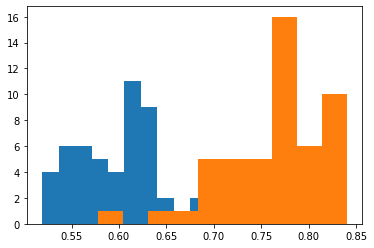

In [ ]:
clu = pd.DataFrame(clu)
aldob = pd.DataFrame(aldob)
lyz1 = pd.DataFrame(lyz1)
muc2 = pd.DataFrame(muc2)
chga = pd.DataFrame(chga)
all_scores = pd.concat([clu, aldob, lyz1, muc2, chga], axis = 1)
all_scores.to_csv(dir + "scores" + out + ".csv")


In [ ]:
print(y_pred)
print(encoder.inverse_transform(y_pred))

[1 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1
 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 1
 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 0 0 1 0
 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 1 0 1 1
 0 0 0 0 1 0 1 1 0 1]
['epithelial' '2-cy3' 'epithelial' '2-cy3' 'epithelial' '2-cy3'
 'epithelial' '2-cy3' 'epithelial' 'epithelial' '2-cy3' '2-cy3'
 'epithelial' '2-cy3' '2-cy3' '2-cy3' 'epithelial' 'epithelial'
 'epithelial' '2-cy3' '2-cy3' '2-cy3' '2-cy3' 'epithelial' 'epithelial'
 '2-cy3' 'epithelial' 'epithelial' '2-cy3' '2-cy3' 'epithelial'
 'epithelial' 'epithelial' 'epithelial' 'epithelial' '2-cy3' 'epithelial'
 '2-cy3' 'epithelial' 'epithelial' '2-cy3' '2-cy3' 'epithelial' '2-cy3'
 '2-cy3' 'epithelial' '2-cy3' '2-cy3' '2-cy3' 'epithelial' 'epithelial'
 'epithelial' 'epithelial' '2-cy3' '2-cy3' 'epithelial' 'epithelial'
 '2-cy3' 'epithelial' '2-cy3' 'epithelial' 'epithelial' '2-cy3'

Text(91.68, 0.5, 'predicted label')

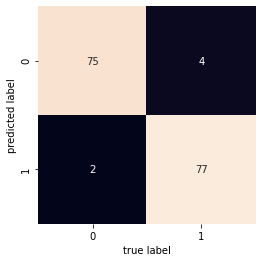

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
mat = confusion_matrix(y_test, y_pred)#, labels = ['2-yfp', '1-yfp'])
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

Text(91.68, 0.5, 'predicted label')

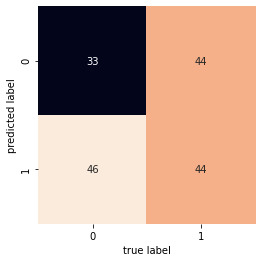

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
mat = confusion_matrix(y_test_labels, y_pred_labels, labels = ['2-cy3', 'epithelial'])
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')